In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [21]:
train_data = pd.read_csv("./data/train_images.csv")
kaggle_data = pd.read_csv('./data/test_images_path.csv')
sample_submission = pd.read_csv("./data/test_images_sample.csv")

class_names = np.load("./data/class_names.npy", allow_pickle=True).item()
attributes = np.load("./data/attributes.npy")

#print(train_labels.head())

for bird in list(class_names.keys()):
    print(bird)

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
004.Groove_billed_Ani
005.Crested_Auklet
006.Least_Auklet
007.Parakeet_Auklet
008.Rhinoceros_Auklet
009.Brewer_Blackbird
010.Red_winged_Blackbird
011.Rusty_Blackbird
012.Yellow_headed_Blackbird
013.Bobolink
014.Indigo_Bunting
015.Lazuli_Bunting
016.Painted_Bunting
017.Cardinal
018.Spotted_Catbird
019.Gray_Catbird
020.Yellow_breasted_Chat
021.Eastern_Towhee
022.Chuck_will_Widow
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
026.Bronzed_Cowbird
027.Shiny_Cowbird
028.Brown_Creeper
029.American_Crow
030.Fish_Crow
031.Black_billed_Cuckoo
032.Mangrove_Cuckoo
033.Yellow_billed_Cuckoo
034.Gray_crowned_Rosy_Finch
035.Purple_Finch
036.Northern_Flicker
037.Acadian_Flycatcher
038.Great_Crested_Flycatcher
039.Least_Flycatcher
040.Olive_sided_Flycatcher
041.Scissor_tailed_Flycatcher
042.Vermilion_Flycatcher
043.Yellow_bellied_Flycatcher
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
047.American_Goldfinch
048.Eu

In [22]:
train_data.sample(20)

,image_path,label
2475,/train_images/2476.jpg,91
3413,/train_images/3414.jpg,144
3125,/train_images/3126.jpg,125
158,/train_images/159.jpg,6
2050,/train_images/2051.jpg,72
1828,/train_images/1829.jpg,63
759,/train_images/760.jpg,26
327,/train_images/328.jpg,12
2458,/train_images/2459.jpg,90
3884,/train_images/3885.jpg,193


In [23]:
print(train_data["label"].value_counts())

# Count of each class goes from 5 to 35
print("Min amount of times a class appears:", (train_data["label"].value_counts()).min())
print("Max amount of times a class appears:", (train_data["label"].value_counts()).max())

label
1      35
4      35
2      35
9      34
10     34
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64
Min amount of times a class appears: 5
Max amount of times a class appears: 35


In [24]:
train_data['class_name'] = train_data['label'].map(
    {v: k for k, v in class_names.items()}  # Reverse the dictionary to map label to class_name
)

train_data['class_name'] = [
    "_".join(name.split('.')[1].split('_')) for name in train_data['class_name']
]

train_data['image_path'] = 'data' + train_data['image_path']
train_data

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


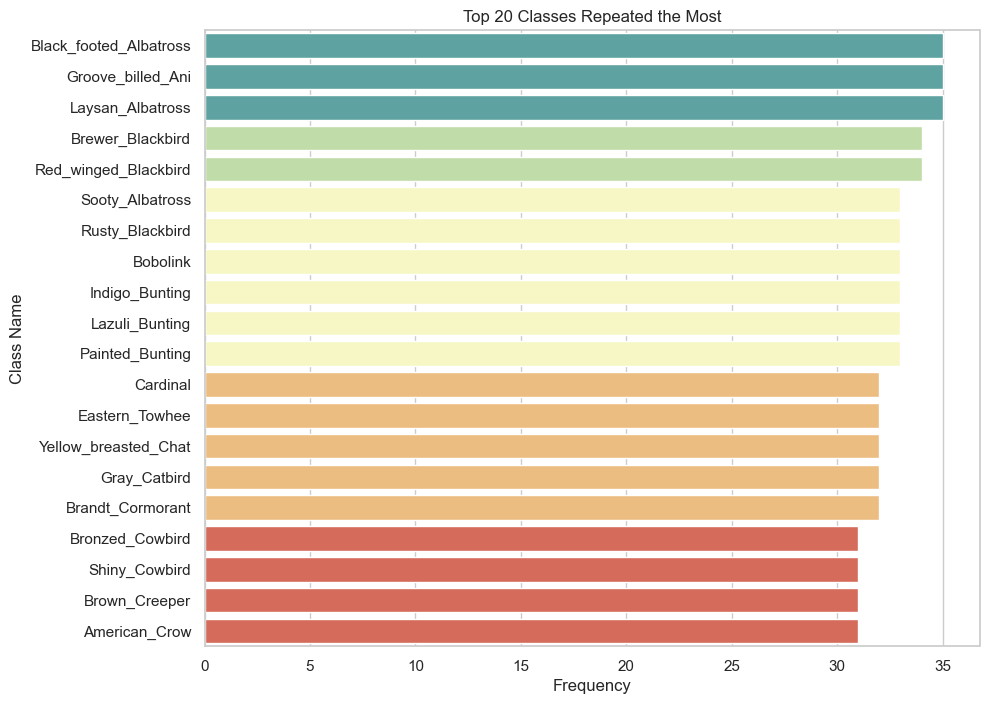

In [25]:
# Let's check beautifully which are the top 20 most repeated bird classes
top_20 = (train_data['class_name'].value_counts()[:20])

color_palette = sns.color_palette("Spectral", len(set(top_20.values)))
frequency_to_color = {freq: color for freq, color in zip(sorted(set(top_20.values)), color_palette)}
bar_colors = [frequency_to_color[freq] for freq in top_20.values]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_20.values,
    y=top_20.index,
    palette=bar_colors
)
plt.xlabel("Frequency")
plt.ylabel("Class Name")
plt.title("Top 20 Classes Repeated the Most")
plt.show()

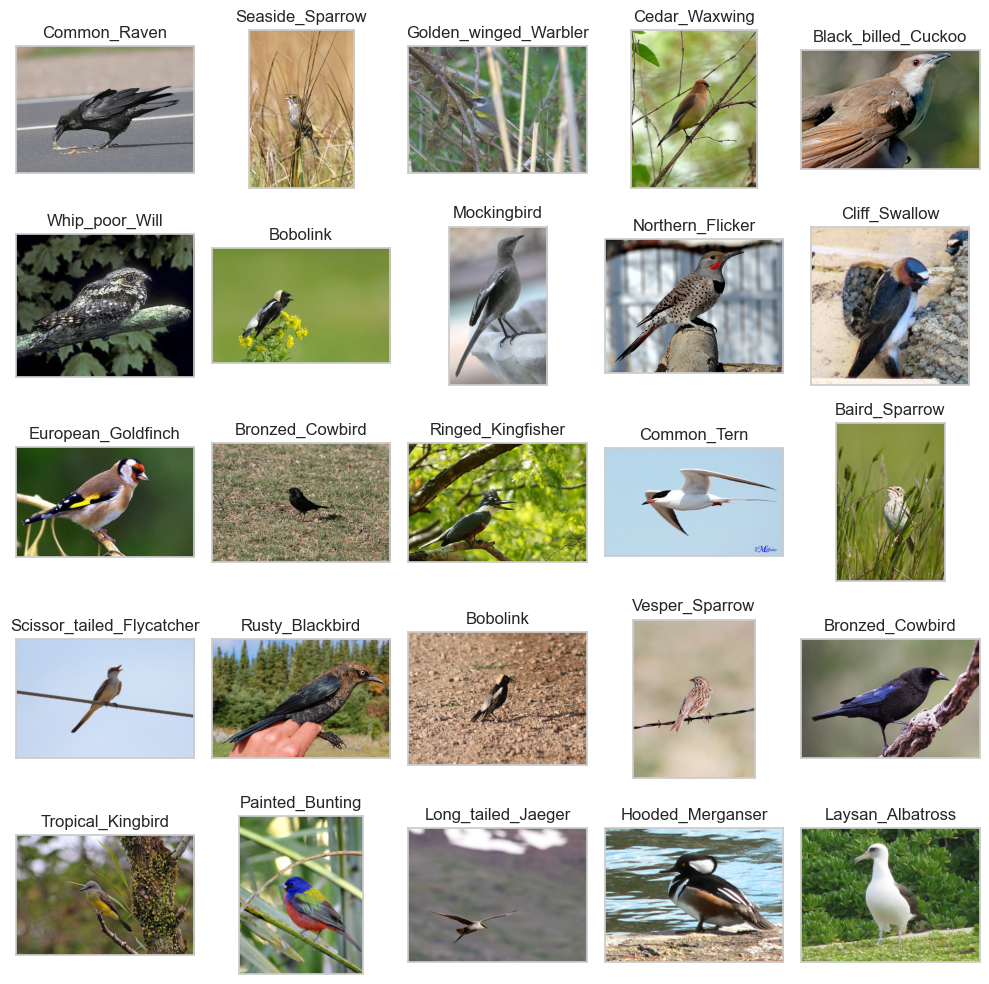

In [26]:
sample_df = train_data.sample(25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()):
    ax.imshow(plt.imread(row['image_path']))
    ax.set_title(row['class_name'])

plt.tight_layout()
plt.show()

In [27]:
attribute_names = []
with open('./data/attributes.txt', 'r') as f:
    for line in f:
        attribute_names.append(line.strip().split(' ')[1])  # Extract the name after the index

# Sanity check: print attribute names
print("Loaded attribute names:\n", attribute_names)

Loaded attribute names:
 ['has_bill_shape::curved_(up_or_down)', 'has_bill_shape::dagger', 'has_bill_shape::hooked', 'has_bill_shape::needle', 'has_bill_shape::hooked_seabird', 'has_bill_shape::spatulate', 'has_bill_shape::all-purpose', 'has_bill_shape::cone', 'has_bill_shape::specialized', 'has_wing_color::blue', 'has_wing_color::brown', 'has_wing_color::iridescent', 'has_wing_color::purple', 'has_wing_color::rufous', 'has_wing_color::grey', 'has_wing_color::yellow', 'has_wing_color::olive', 'has_wing_color::green', 'has_wing_color::pink', 'has_wing_color::orange', 'has_wing_color::black', 'has_wing_color::white', 'has_wing_color::red', 'has_wing_color::buff', 'has_upperparts_color::blue', 'has_upperparts_color::brown', 'has_upperparts_color::iridescent', 'has_upperparts_color::purple', 'has_upperparts_color::rufous', 'has_upperparts_color::grey', 'has_upperparts_color::yellow', 'has_upperparts_color::olive', 'has_upperparts_color::green', 'has_upperparts_color::pink', 'has_upperparts

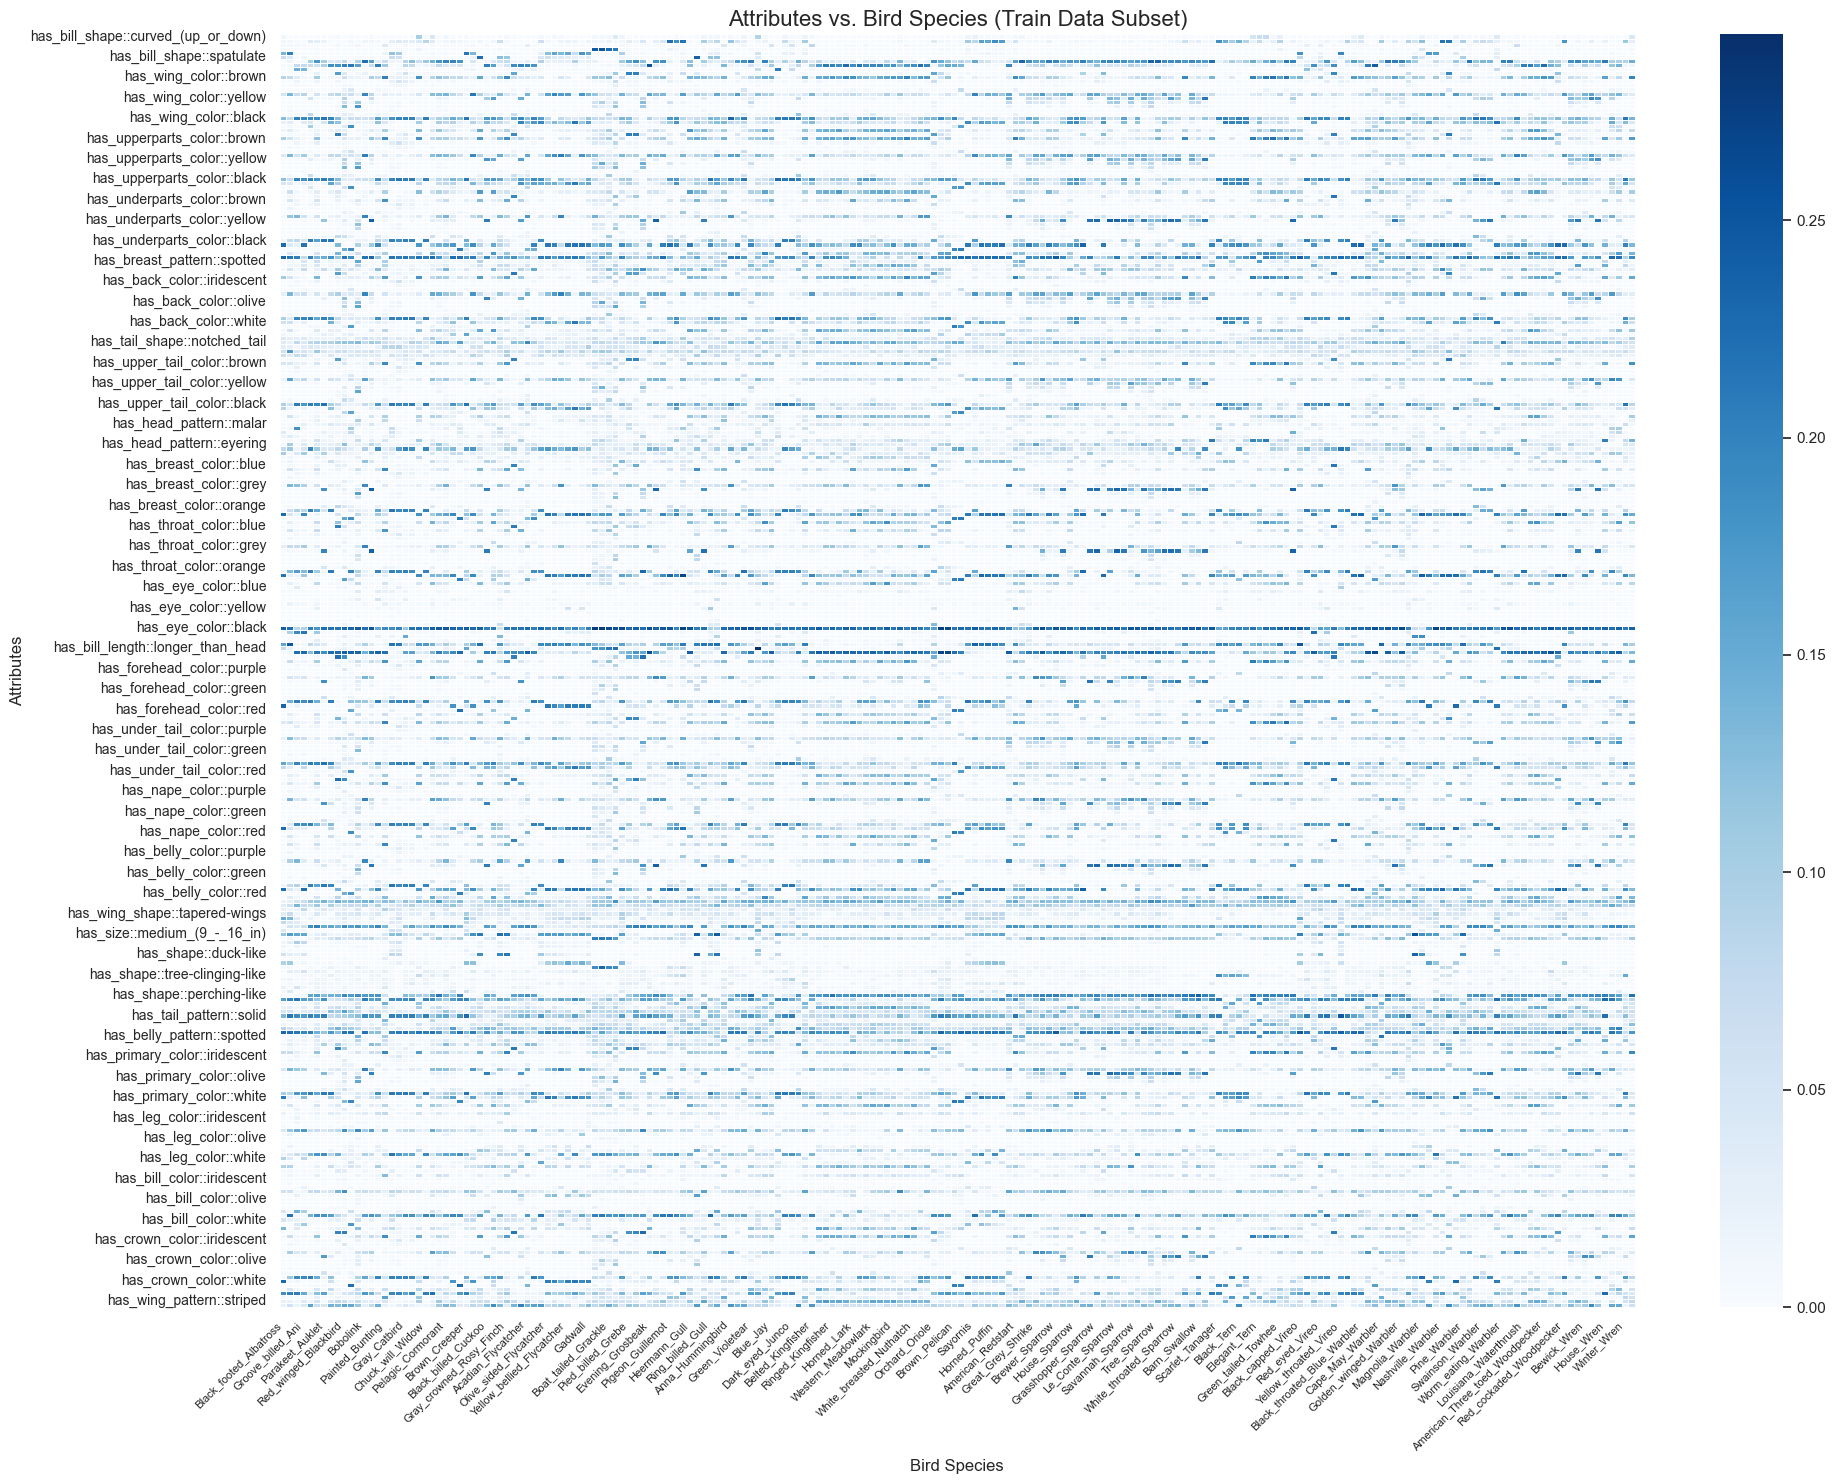

In [28]:
class_name_to_label = {row['class_name']: row['label'] for _, row in train_data.iterrows()}

att_matrix = pd.DataFrame(attributes, columns=attribute_names)
att_matrix.index = [
    class_name for class_name, label in class_name_to_label.items()
    if label <= len(att_matrix)
]

species = train_data['class_name'].unique()
matrix = att_matrix.loc[species]

# heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(matrix.T, cmap="Blues", cbar=True, linewidths=0.5)

plt.title("Attributes vs. Bird Species (Train Data Subset)", fontsize=16)
plt.xlabel("Bird Species", fontsize=12)
plt.ylabel("Attributes", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Processing #

In [29]:
train_data

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


# Pytorch #

In [176]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load CSV data
train_data = pd.read_csv("./data/train_images.csv")

train_data['image_path'] = 'data' + train_data['image_path']

train_df, temp_df = train_test_split(
    train_data, 
    test_size=0.3,
    stratify=train_data['label'],
    random_state=42
)

test_df, val_df = train_test_split(
    temp_df, 
    test_size=0.5,
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Using cpu device
Training set size: 2748
Validation set size: 589
Test set size: 589


In [177]:
len(train_df['label'].value_counts())

200

`Dataset` and `DataLoader` classes form PyTorch to create an efficient dataset pipeline to achieve baseline functionality

In [178]:
class BirdieDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.n_classes = len(train_df['label'].value_counts())
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.df.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        # 0-based indexing
        label = int(self.df.iloc[index, 1]) - 1
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [179]:
# Transforms
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Rotation for diversity
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.Normalize(mean = 0, std = 1)
])

debug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),  # Keep only ToTensor for visual clarity
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.Normalize(mean = 0, std = 1),
])

In [180]:
BATCH_SIZE = 32
NUM_CLASSES = 200

train_dataset = BirdieDataset(train_df, "", transform=train_transform)
val_dataset = BirdieDataset(val_df, "", transform=val_test_transform)
test_dataset = BirdieDataset(test_df, "", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [181]:
# CNN model
class Birdie_CNN(nn.Module):
    def __init__(self, num_classes):
        super(Birdie_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2 )
        self.dropout = nn.Dropout(0.4)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_conv2 = nn.BatchNorm2d(64)
        self.bn_conv3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # conv 1
        x = self.pool(self.relu(self.bn_conv1(self.conv1(x))))
        x = self.dropout(x)

        # conv 2
        x = self.pool(self.relu(self.bn_conv2(self.conv2(x))))
        x = self.dropout(x)

        # conv 3
        x = self.pool(self.relu(self.bn_conv3(self.conv3(x))))
        x = self.dropout(x)
        
        # flatten
        x = torch.flatten(x, start_dim=1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

In [182]:
model = Birdie_CNN(NUM_CLASSES).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [183]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        # training process
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # validation process
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"epoch {epoch+1}/{epochs}, train Loss: {train_loss/len(train_loader):.4f}, "
              f"val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {100 * correct / total:.2f}%")

# train the model
train_validate(model, train_loader, val_loader, criterion, optimizer, epochs=10)

epoch 1/10, train Loss: 73.7854, val Loss: 5.2505, Val Accuracy: 0.51%
epoch 2/10, train Loss: 5.2551, val Loss: 5.2213, Val Accuracy: 0.85%
epoch 3/10, train Loss: 5.2312, val Loss: 5.2076, Val Accuracy: 0.51%
epoch 4/10, train Loss: 5.2239, val Loss: 5.1989, Val Accuracy: 0.51%
epoch 5/10, train Loss: 5.2181, val Loss: 5.1961, Val Accuracy: 0.51%
epoch 6/10, train Loss: 5.2147, val Loss: 5.1929, Val Accuracy: 0.51%
epoch 7/10, train Loss: 5.2138, val Loss: 5.1913, Val Accuracy: 0.51%
epoch 8/10, train Loss: 5.2132, val Loss: 5.1907, Val Accuracy: 0.51%
epoch 9/10, train Loss: 5.2127, val Loss: 5.1907, Val Accuracy: 1.02%
epoch 10/10, train Loss: 5.2130, val Loss: 5.1897, Val Accuracy: 0.51%
